In [1]:
import pandas as pd
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', -1)
import datetime
startTime = datetime.datetime.now()
print(str(startTime))

2019-02-25 13:29:27.962881


**Read in file**

In [2]:
%%time
column_names=['Name', 'ScreenName', 'UserID', 'FollowersCount', 'FriendsCount', 'Location', 'Description', 'CreatedAt', 'StatusID', 'Language', 'Place', 'RetweetCount', 'FavoriteCount', 'Text']
tweets = pd.read_csv('clinton_trump_tweets.txt', sep="\t",  encoding="ISO-8859-1", header=None, names=column_names)
#print initial data
tweets.Location = tweets.Location.astype(str)
tweets.head(20)

CPU times: user 36.2 s, sys: 2.17 s, total: 38.4 s
Wall time: 38.2 s


**Filter out tweets that start with 'RT'**

In [3]:
#1.1 filter retweets
tweets = tweets[~tweets.Text.str.startswith("RT")]
tmp = tweets.Text.str.extract(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')

In [4]:
tmp["Merges"] =  tmp[0]+"://"+tmp[1]+tmp[2]
tmp.Merges = tmp.Merges.astype(str)

In [5]:
# Not using this since it is very inefficient
# %%time
# def keepHandlesAndMention(text):
#     handlesAndMentions = []
#     words =  text.split()
#     for word in words:
#         if((word.startswith('@') or word.startswith('#')) and len(word) > 1):
#             handlesAndMentions.append(word)
#     return ' '.join(handlesAndMentions)
# tweets['HashMentions'] = tweets.Text.apply(keepHandlesAndMention)

In [6]:
%%time
def keepHashMentions(text):
    hashMentions = []
    for word in text:
        hashMentions.extend(word)
    return " ".join(hashMentions).strip()
tweets['HashMentions'] = tweets.Text.str.findall('(@\w+)|(#\w+)').apply(keepHashMentions)

CPU times: user 13.8 s, sys: 359 ms, total: 14.2 s
Wall time: 14 s


**Filter out tweets that have mention/hashtag < 20**

In [7]:
%%time
# Generate a list of mention/hashes that have a frequency of 20+
top_hash = pd.Series(tweets['HashMentions'].str.cat(sep=' ').split()).value_counts()
top20 = top_hash[top_hash>=20]
top20List = top20.index.tolist()

CPU times: user 3.2 s, sys: 129 ms, total: 3.33 s
Wall time: 2.82 s


In [8]:
# Convert list to set so it will have quick lookup
top20Set =  set(top20List)

In [9]:
%%time
# generate list of mention/hashes that occur 20+ times from our orginal list 
def removeUnder20Mentions(hashMentions):
    mentions =  hashMentions.split()
    mentionsOver20 = []
    for mention in mentions:
        if(mention in top20Set):
            mentionsOver20.append(mention)
    return " ".join(mentionsOver20)
tweets['FrequencyOver20'] = tweets.HashMentions.apply(removeUnder20Mentions)


CPU times: user 1.98 s, sys: 23.4 ms, total: 2.01 s
Wall time: 2.01 s


In [10]:
# remove tweets that don't have any mention/hashes that occure 20+ times
tweets = tweets[tweets.FrequencyOver20 != '']

**Filter out users that have less than 20 tweets**

In [11]:
#1.2 keep tweets where UID appears 20+ times
tweets = tweets.groupby("UserID").filter(lambda x: len(x) >= 20)

**Plot top 30 locations**

In [12]:
# Remove locations that are null 
tweets['LocationSplit'] = tweets.Location.apply(lambda x: x.split(',')[0])
# creating new tweets dataframe since we don't want to alter the data for other visualizations
tweetsLocations = tweets[tweets.LocationSplit.notnull()]
tweetsLocations = tweetsLocations[tweetsLocations.LocationSplit != 'nan']
tweetsLocations.LocationSplit = tweetsLocations.LocationSplit.map({'NYC':'New York','New York City':'New York','United States':'USA', "United States of America": 'USA'}).fillna(tweetsLocations.LocationSplit)

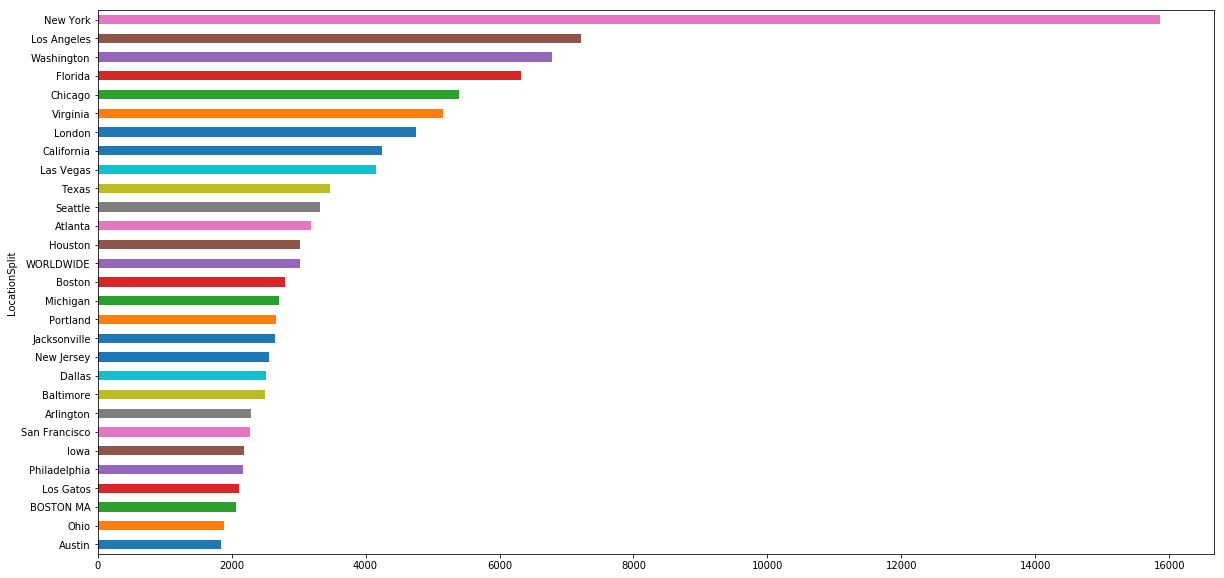

In [13]:
#2.1
tweetsTop30Locations = tweetsLocations[tweetsLocations.LocationSplit.isin(tweetsLocations.LocationSplit.value_counts().nlargest(30).index.tolist())]
tweetsTop30Locations[tweetsTop30Locations.LocationSplit != 'USA'].groupby("LocationSplit").LocationSplit.count().sort_values(ascending=True).plot(kind='barh',figsize=(20,10))

**Make word cloud of the top 3 locations**

In [14]:
tweetsTop3Locations = tweetsLocations[tweetsLocations.LocationSplit.isin(tweetsLocations.LocationSplit.value_counts().nlargest(3).index.tolist())]
text = " ".join(tweet for tweet in tweetsTop3Locations.Text)

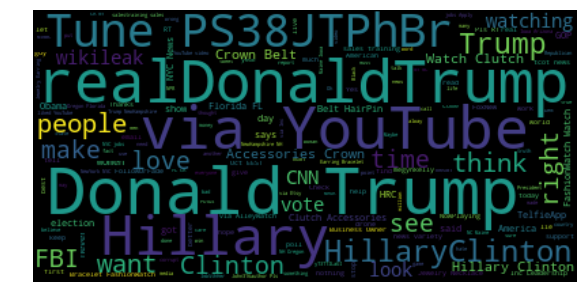

In [15]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["way","back","null","en","say","new","go","ye","thing","well","big","us","great","https", "still", "need", "co", "one","will","Thank","know","going","lol","good", "take","even","really","now"])
stopwords.update(tmp.Merges.unique().flatten())

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords).generate(text)

# Display the generated image:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Plot number of tweets of top 50 users**

In [16]:
tweetsTop50Users = tweets[tweets.UserID.isin(tweets.UserID.value_counts().nlargest(50).index.tolist())]

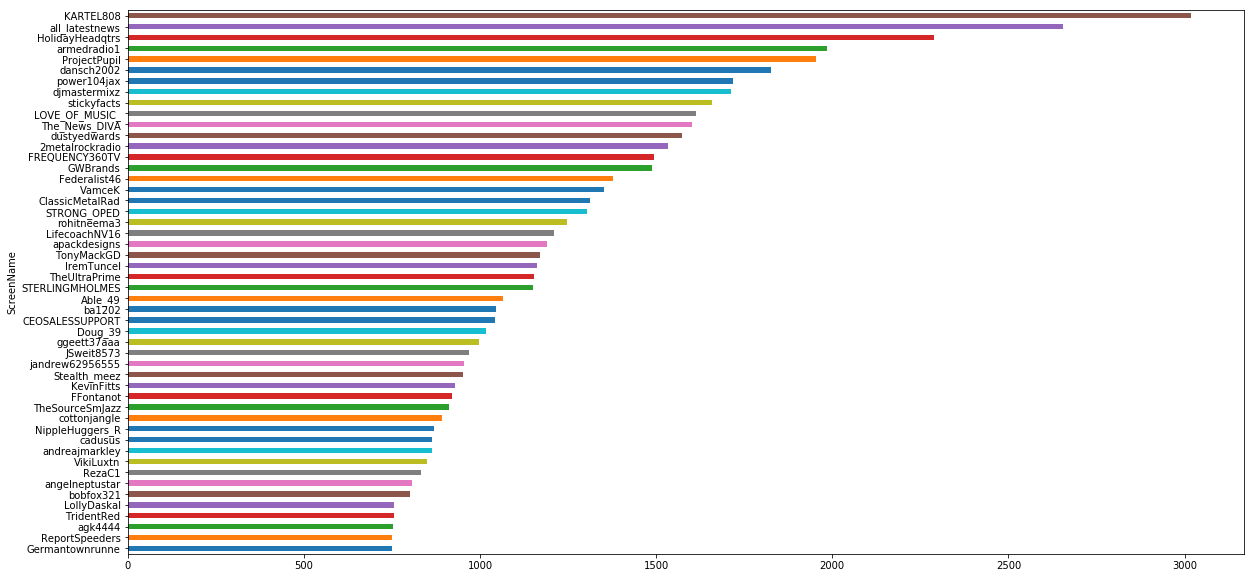

In [17]:
tweetsTop50Users.groupby("ScreenName").ScreenName.count().sort_values().plot(kind='barh',figsize=(20,10))

**Word cloud of top 3 users**

In [18]:
tweetsTop3Users = tweets[tweets.UserID.isin(tweets.UserID.value_counts().nlargest(3).index.tolist())]
top3UsersText = " ".join(" ".join(tweet.split()) for tweet in tweetsTop3Users.Text)

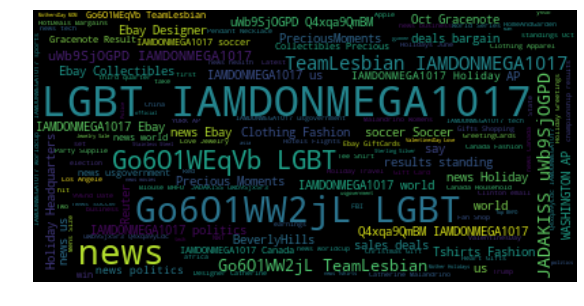

In [27]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["YOUNGMA", "https", "co", "DOWNLOAD", "CJRr8Y9xHM","Go601WW2jL","go601WW2jL","Go601WW2jL","ALBUM","SPOTIFY","NEW","Go601WEqVB","go601WEqVb","Go601WW2jL","nyLCGWJRt0","uWb9Sj0GPD","CJRr8Yr8zk"])
stopwords.update(tmp.Merges.unique().flatten())

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords).generate(top3UsersText)

# Display the generated image:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Top 100 mentions/hashtags**

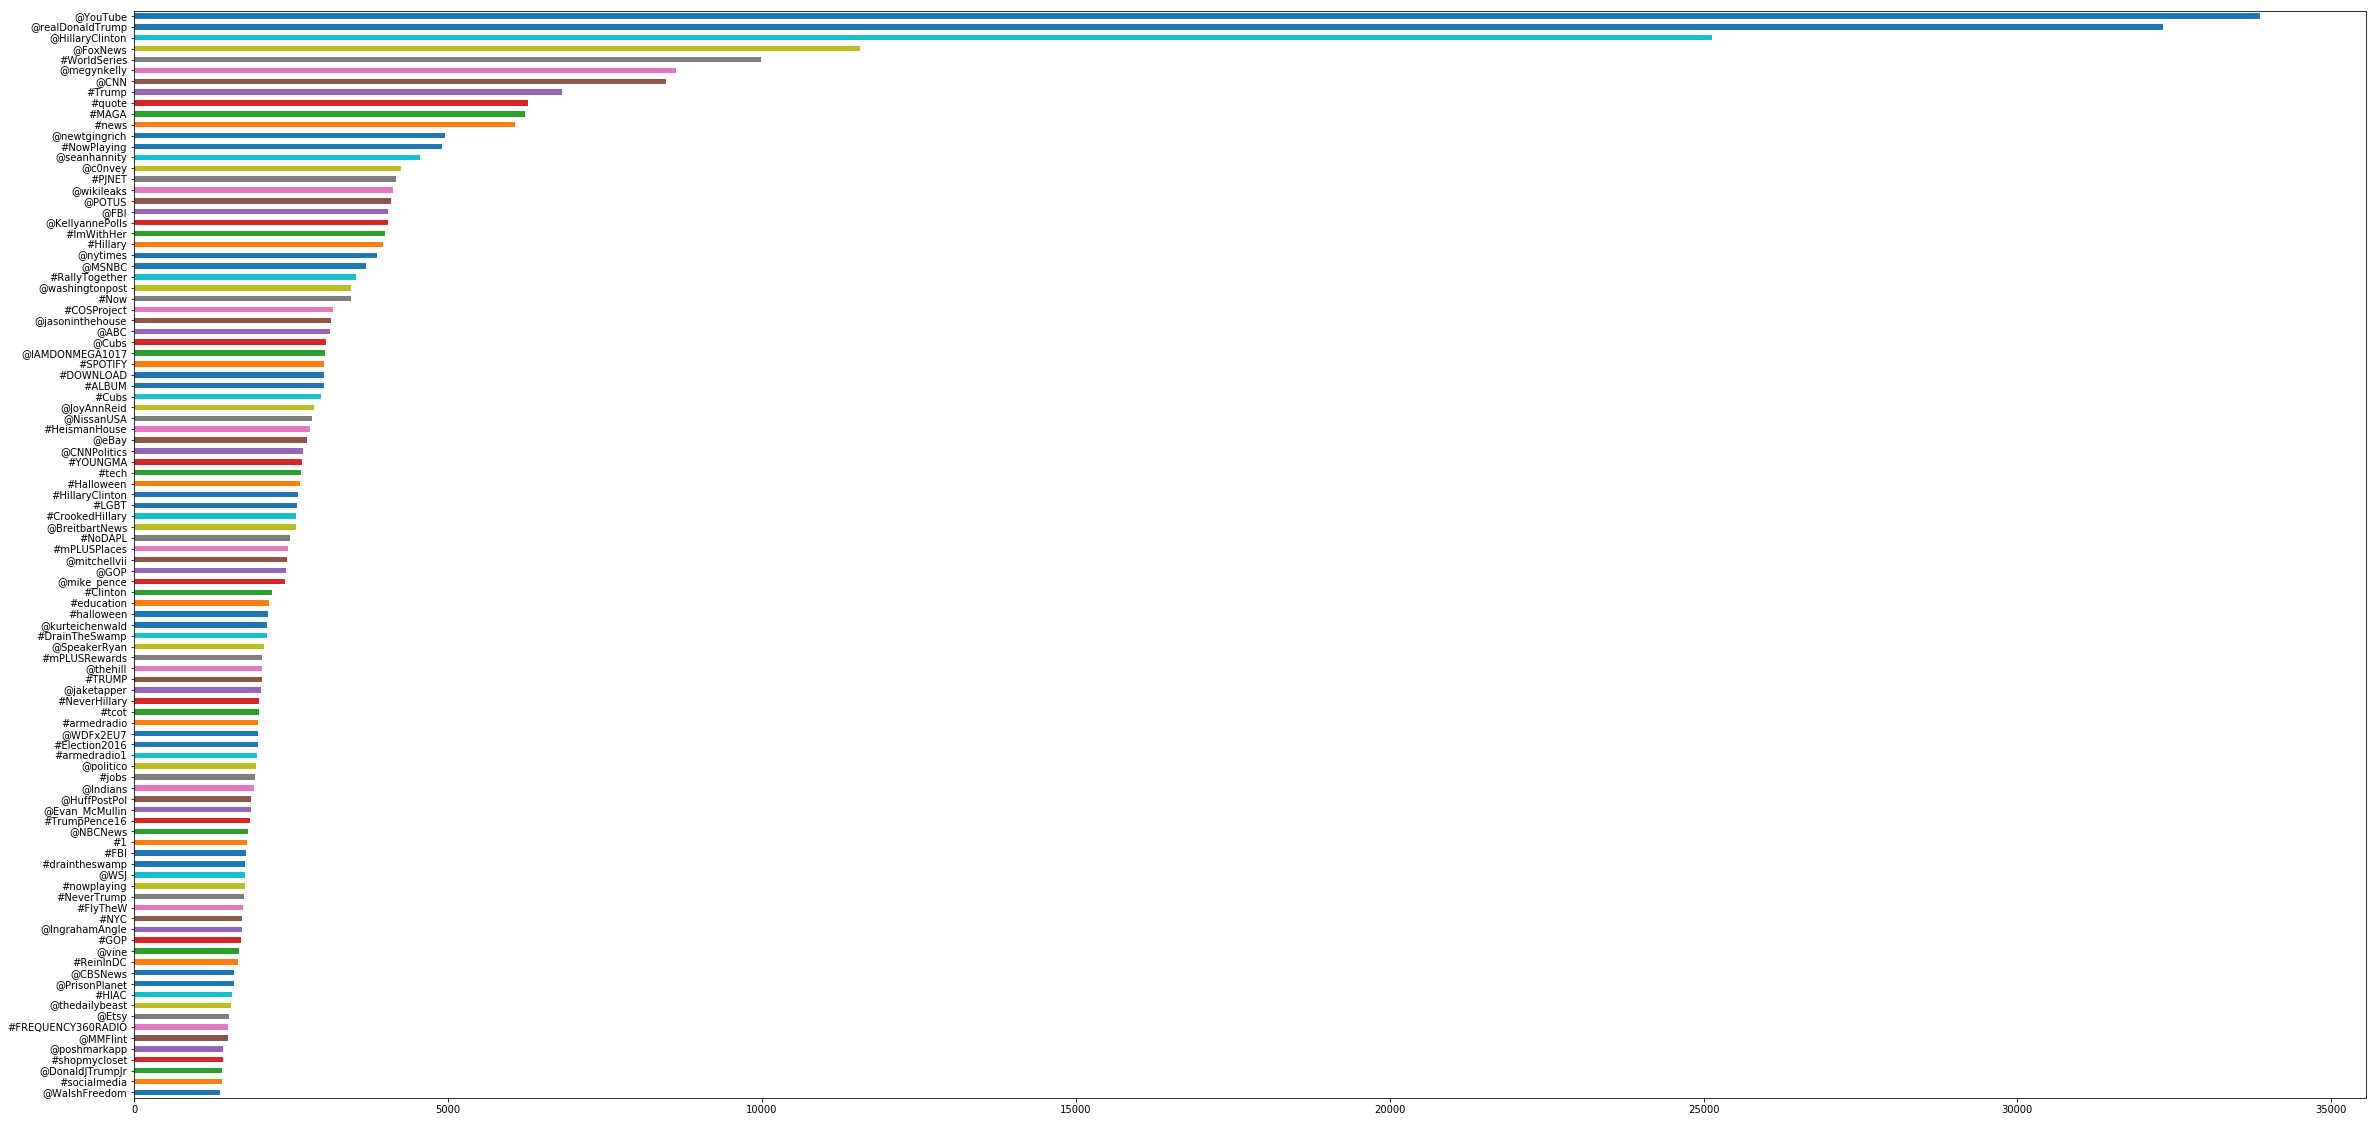

In [23]:
top_hash.nlargest(100).sort_values(ascending=True).plot(kind='barh',figsize=(40,20))
text = " ".join(tweet for tweet in tweets.HashMentions)

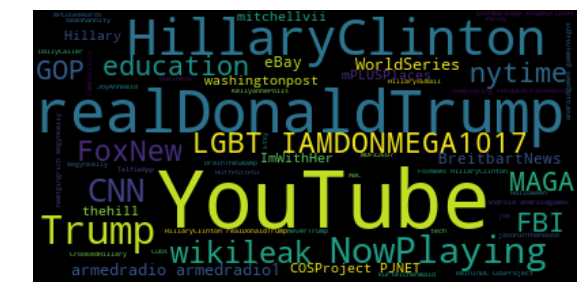

In [24]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["Now","DOWNLOAD","c0nvey","ALBUM","YOUNGMA","Cub","DOWNLOAD", "SPOTIFY","quote"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords).generate(text)

# Display the generated image:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
endTime = datetime.datetime.now()
print(str(endTime))
print(str(endTime-startTime))

2019-02-25 13:31:25.660337
0:01:57.697456
